In [1]:
import os
import tensorflow as tf
import numpy as np
from PIL import Image
from pathlib import Path
import math
import keras_cv
import matplotlib.pyplot as plt
import keras_cv.visualization as visualization
import cv2
import keras
from keras_cv import models, losses, callbacks
import keras_cv.losses as losses
from keras_cv.models import YOLOV8Detector
import matplotlib.patches as patches
from tensorflow import data as tf_data
import tensorflow_datasets as tfds
import keras
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
from keras_cv import visualization
import tqdm

## Data Input Pipeline

In [2]:
IMAGE_SIZE = (640, 640)  # Input size for YOLOv8
BATCH_SIZE = 3  # Number of samples per batch
NUM_CLASSES = 1  # Example number of classes, adjust as needed
BOUNDING_BOX_FORMAT = "xywh"  # YOLO bounding box format
PAD_TO_ASPECT_RATIO = True  # To maintain aspect ratio when resizing
LEARNING_RATE = 0.001
EPOCH = 1
GLOBAL_CLIPNORM = 10.0

In [3]:
# Paths to the datasets
TRAIN_IMAGES_DIR = Path("dataset/train/images/")
TRAIN_LABELS_DIR = Path("dataset/train/labels/")

VAL_IMAGES_DIR = Path("dataset/val/images/")
VAL_LABELS_DIR = Path("dataset/val/labels/")

In [4]:
# Function to load YOLO annotations
def load_yolo_annotations(label_path, image_size):
    annotations = []
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split(" ")
            if len(parts) != 5:
                continue  # Skip lines that don't match expected format

            class_id = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])

            # Convert normalized "xywh" to pixel-based "xyxy" format
            x_min = (x_center - width / 2) * image_size[0]
            y_min = (y_center - height / 2) * image_size[1]
            x_max = (x_center + width / 2) * image_size[0]
            y_max = (y_center + height / 2) * image_size[1]

            annotations.append([class_id, x_min, y_min, x_max, y_max])

    return np.array(annotations, dtype=np.float32)

In [5]:
# Function to load image and corresponding annotations
def load_sample(image_path, labels_dir):
    #tf.keras.backend.get_value(image_path) fetches the actual value "image_path" from tensor
    #.decode(utf-8) converts byte representation of the string to a regular utf-8 encoded python string
    image_path_str = tf.keras.backend.get_value(image_path).decode("utf-8")  # Convert tensor to string
    image = Image.open(image_path_str).resize(IMAGE_SIZE)  # Resize to 640x640
    image = np.array(image) / 255.0  # Normalize
    
    # Construct the label path and validate its existence

    # stem is the base name without the file extension
    image_stem = Path(image_path_str).stem
    label_path = os.path.join(labels_dir, image_stem + ".txt")

    if not os.path.isfile(label_path):
        raise FileNotFoundError(f"Label file not found: {label_path}")

    # Load YOLO annotations
    annotations = load_yolo_annotations(label_path, IMAGE_SIZE)  # Load annotations
    return image, annotations

In [6]:
# Function to separate class IDs from bounding box coordinates
def extract_bounding_box_info(bounding_boxes_raw):
    # Check if the last dimension has five elements
    if bounding_boxes_raw.shape[-1] == 5:
        # Extract the class ID (last element) and bounding box coordinates
        class_ids = bounding_boxes_raw[: ,0]  # The first element is the class ID
        bounding_boxes = bounding_boxes_raw[:, 1:]  # The rest is the bounding box coordinates
    else:
        raise ValueError(f"Unexpected bounding box shape: {bounding_boxes_raw.shape}")
    return class_ids, bounding_boxes 

In [7]:
# Function to filter out empty annotations
def filter_empty_annotations(image, annotations):
    #Computer the total number of elements size in a tensor
    return tf.size(annotations) > 0  # Check if there are any annotations

In [37]:
# def pad_annotations(image, annotations, max_annotations_row=1, max_annotations_col=4):
#     rows = 1 # Number of rows we are considering in our reshaping 
#     cols = 4 # Number of cols we are considering in our reshaping
    
#     # Get the number of annotations
#     num_annotations_row = tf.shape(annotations)[0]
#     num_annotations_col = tf.shape(annotations)[1]

#     # Reshape the annotations to ensure it has the shape [1,5]
#     # retreive tensor shape that represents the shape of "annotations", then extract
#     # the size of the first dimension
#     annotations = tf.reshape(annotations, [rows, 5])

#     #Calculate the padding required to match max_annotations
#     # padding is a list of lists, where each inner list defines how much padding
#     # to add for each dimension. 
#     # Here, we pad the first dimension and not the second 
#     # How much elements to add to create "max_annotations" in our case, 1 row
#     padding = [[0, max_annotations_row - num_annotations_row], [0,0]]
#     annotations = tf.pad(annotations, padding, constant_values=-1)

#     # sess = tf.compat.v1.Session()
#     # annotations = sess.run(annotations)

#     # annotations = np.array(annotations)
    
#     # extracts specific column from the annotations tensor. 
#     #:,0 extracts all rows and first column
#     classes = tf.expand_dims(annotations[:, 0], axis=-1)
#     boxes = annotations[:, 1:]
#     # # classes = annotations[:, 0]
#     # boxes = annotations[:, 1:]
    
#     return image, {'classes': classes, 'boxes': boxes}



# def pad_annotations(image, annotations, max_annotations=1):
#     # Get the number of annotations
#     num_annotations = tf.shape(annotations)[0]

#     # Separate class name and bounding boxes
#     class_name = annotations[:, 0]  # First column is the class name
#     bboxes = annotations[:, 1:]     # Remaining columns are the bounding boxes

#     # Calculate padding required to match max_annotations for class names and bounding boxes
#     padding_class = [[0, max_annotations - num_annotations]]
#     padding_bboxes = [[0, max_annotations - num_annotations], [0, 0]]

#     # Pad class names and bounding boxes
#     class_name = tf.pad(class_name, padding_class, constant_values=-1)
#     bboxes = tf.pad(bboxes, padding_bboxes, constant_values=-1)

#     # Reshape class_name to (batch_size, 1, 4, 1)
#     class_name = tf.reshape(class_name, [max_annotations, 1, 4, 1])

#     # Reshape bboxes to (batch_size, 4, 1, 1)
#     bboxes = tf.reshape(bboxes, [max_annotations, 4, 1, 1])

#     return image, {'classes': class_name, 'boxes': bboxes}


def pad_annotations(image, annotations, max_annotations=1):
    # Get the number of annotations
    num_annotations = tf.shape(annotations)[0]

    # Separate class name and bounding boxes
    class_name = annotations[:, 0:1]  # First column is the class name, keep it as 2D tensor
    bboxes = annotations[:, 1:]      # Remaining columns are the bounding boxes

    # Calculate padding required to match max_annotations for class names and bounding boxes
    padding_class = [[0, max_annotations - num_annotations], [0, 3]]  # Pad to match (max_annotations, 4)
    padding_bboxes = [[0, max_annotations - num_annotations], [0, 0]] # Just pad the number of rows

    # Pad class names and bounding boxes
    class_name = tf.pad(class_name, padding_class, constant_values=-1)
    bboxes = tf.pad(bboxes, padding_bboxes, constant_values=-1)

    # Expand dimensions to match the target shape
    class_name = tf.expand_dims(class_name, axis=1)  # Add a new axis after the batch size
    # class_name = tf.expand_dims(class_name, axis=-1) # Add a new axis at the end
    bboxes = tf.expand_dims(bboxes, axis=1)          # Add a new axis at the 3rd dimension
    # bboxes = tf.expand_dims(bboxes, axis=-1)         # Add a new axis at the end

    return image, {'classes': class_name, 'boxes': bboxes}




In [38]:
def data_loader(images_dir, labels_dir, batch_size):
    image_paths = list(Path(images_dir).rglob("*.jpg")) + list(Path(images_dir).rglob("*.png"))

    if len(image_paths) == 0:
        raise ValueError(f"No images found in {images_dir}. Check your dataset path.")

    dataset = tf.data.Dataset.from_tensor_slices([str(p) for p in image_paths])

    def load_sample_with_shape(image_path):
        image, annotations = tf.py_function(
            lambda y: load_sample(y, labels_dir),
            [image_path],
            [tf.float32, tf.float32]
        )
        image.set_shape(IMAGE_SIZE + (3,))
        annotations.set_shape([None, 5])
        return image, annotations

    dataset = dataset.map(load_sample_with_shape, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.filter(lambda image, annotations: tf.py_function(
        func=filter_empty_annotations,
        inp=[image, annotations],
        Tout=tf.bool)
    )

    dataset = dataset.map(lambda image, annotations: pad_annotations(image, annotations), num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size, drop_remainder=False).prefetch(tf.data.AUTOTUNE)

    return dataset

In [39]:
# Create datasets for training, validation, and testing
train_dataset = data_loader(TRAIN_IMAGES_DIR, TRAIN_LABELS_DIR, BATCH_SIZE)
val_dataset = data_loader(VAL_IMAGES_DIR, VAL_LABELS_DIR, BATCH_SIZE)

In [40]:
for batch in train_dataset.take(1):
    images = batch[0]
    labels = batch[1]
    print(images.shape)
    print(labels["classes"].shape)
    print(labels["boxes"].shape)

(3, 640, 640, 3)
(3, 1, 1, 4)
(3, 1, 1, 4)


## Visualization

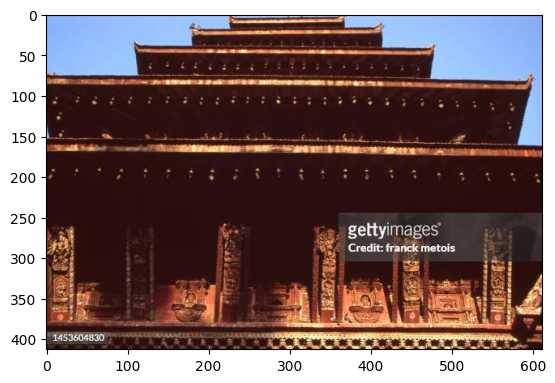

In [59]:
%matplotlib inline
img = Image.open(Path("D:/Projects/DL/MonumentDetection/DL/dataset/train/images/1c2822e4-image_480.png"))
img = np.asarray(img)
imgplot = plt.imshow(img)

In [ ]:
for batch in train_dataset.take(1):  # Take the first batch
    images = batch[0]  # Assuming images are the first element
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(images):
        plt.subplot(2, 2, i + 1)  # Assuming only 1 image in the batch
        plt.imshow(image.numpy())
        plt.axis('off')
    plt.show()

Image shape: (640, 640, 3)
Number of valid boxes: 1
Valid boxes: [[179.3936    3.87872 432.4848  864.9699 ]]
Valid classes: [[0.]]
Image shape: (640, 640, 3)
Number of valid boxes: 1
Valid boxes: [[ 22.63264 113.6096  226.32608 340.8288 ]]
Valid classes: [[0.]]
Image shape: (640, 640, 3)
Number of valid boxes: 1
Valid boxes: [[ 24.66016   4.66624 573.064   325.33313]]
Valid classes: [[0.]]


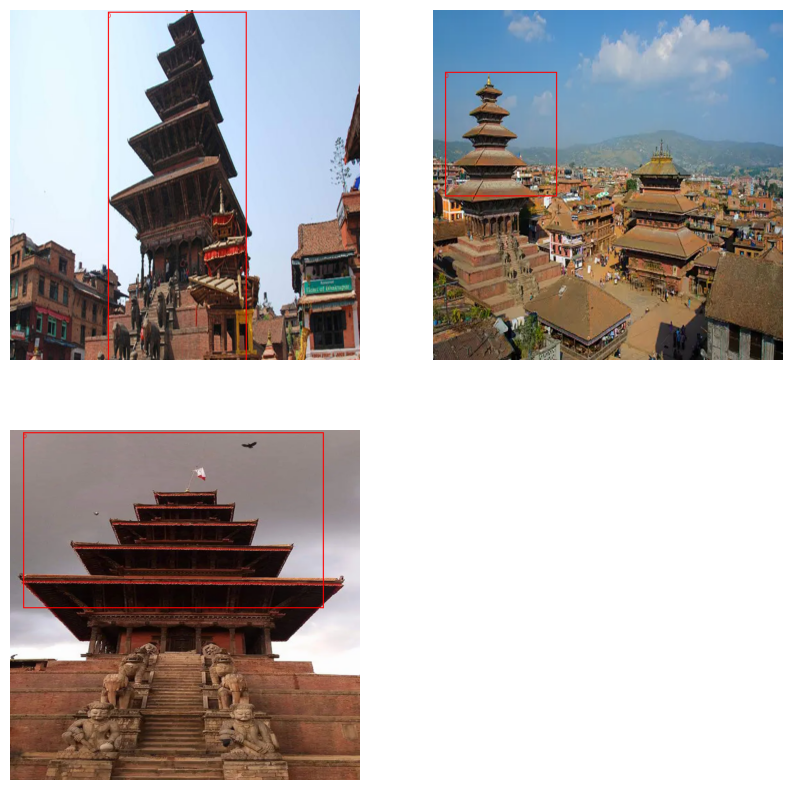

In [226]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import tensorflow as tf

def visualize_image_with_bboxes(image, boxes, class_labels, bbox_color='red', bbox_width=2):
    """
    Visualize an image with bounding boxes and class labels.
    
    Parameters:
    - image: Tensor image.
    - boxes: List of bounding boxes.
    - class_labels: List of class labels corresponding to bounding boxes.
    - bbox_color: Color of the bounding box.
    - bbox_width: Width of the bounding box line.
    """
    # Convert Tensor image to PIL Image
    image_np = (image.numpy() * 255).astype('uint8')
    image_pil = Image.fromarray(image_np)
    draw = ImageDraw.Draw(image_pil)

    for box, label in zip(boxes, class_labels):
        xmin, ymin, xmax, ymax = box.numpy()
        
        if (ymax - ymin) > 0 and (xmax - xmin) > 0:
            draw.rectangle([xmin, ymin, xmax, ymax], outline=bbox_color, width=bbox_width)
            draw.text((xmin, ymin), str(int(label.numpy()[0])), fill=bbox_color)

    return image_pil

for batch in train_dataset.take(1):
    images = batch[0]
    ground_truths = batch[1]
    plt.figure(figsize=(10, 10))
    boxes = ground_truths['boxes']
    class_labels = ground_truths['classes']

    for i, (image, box, class_label) in enumerate(zip(images, boxes, class_labels)):
        plt.subplot(2, 2, i + 1)
        print(f"Image shape: {image.shape}")

        # Filter out invalid boxes
        valid_indices = tf.where(box[:, 2] > 0)
        valid_boxes = tf.gather_nd(box, valid_indices)
        valid_classes = tf.gather_nd(class_label, valid_indices)
        num_valid_boxes = valid_boxes.shape[0]

        print(f"Number of valid boxes: {num_valid_boxes}")
        print(f"Valid boxes: {valid_boxes.numpy()}")
        print(f"Valid classes: {valid_classes.numpy()}")

        image_with_bboxes = visualize_image_with_bboxes(image, valid_boxes, valid_classes)
        plt.imshow(image_with_bboxes)
        plt.axis("off")
        
    plt.show()


In [227]:
# Seems like an easier way of visualization

# def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
#     inputs = next(iter(inputs.take(1)))
#     images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
#     visualization.plot_bounding_box_gallery(
#         images,
#         value_range=value_range,
#         rows=rows,
#         cols=cols,
#         y_true=bounding_boxes,
#         scale=5,
#         font_scale=0.7,
#         bounding_box_format=bounding_box_format,
#         class_mapping=class_mapping,
#     )


# visualize_dataset(
#     train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
# )

# visualize_dataset(
#     val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2

# Model

In [41]:
class_ids = [
    "Nyatapola"
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

In [42]:
# backbone model: initial part of the neural network responsible for extracting
# meaningful features from the input images. 
# In yolo and similar architectures, the backbone typically consists of 
# convolutional layers that progressively downsample the spatial dimensions of
# the input image while increasing the number of feature channels. 
# basically acts as a feature extractor, transforming the raw pixel values of the
# input image into a higher-level representation that is more suitable for
# object detection tasks. 

backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco"  # We will use yolov8 small backbone with coco weights
)

In [43]:
# label encoder

# converts human-readable annotations into a format suitable for training a nn-
# model. In context of yolo:
# 1. annotation parsing: reads annotations associated with training data
# 2. transforms annotations into a format suitable for training the yolo model
# 3. dimensionality and format adjustment 
# 4. batch preparation 
# 5. integration with training pipeline

# def custom_label_encoder(annotations):
#     bounding_boxes, class_ids = extract_bounding_box_info(annotations)

#     # convert class ids into one-hot encoding
#     num_classes = len(class_ids)
#     one_hot_class_ids = tf.one_hot(class_ids, depth=num_classes)

#     # concatenate bounding boxes with one-hot class IDs
#     encoded_annotations = tf.concat([bounding_boxes, one_hot_class_ids], axis = -1)

#     return encoded_annotations

In [44]:
# global_clipnorm: This parameter sets the global norm value to which 
# you want to clip the gradients during training. Clipping gradients can
# help prevent the exploding gradient problem, which can occur during 
# training when gradients become too large. Setting a value for 
# global_clipnorm ensures that the gradient norm doesn't exceed this threshold.

optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

In [45]:
# build a yolov8 model which accepts a feature extractor as the backbone argument
# , a num_classes argument that specifies the number of object classes to detect
# based on the size of the class_mapping list and a bounding_box_format arg
# the informs the model of the format of bbox in the dataset, and finally, 
# the feature pyramid network (fpn) depth is specified by the 
# fpn_depth argument

# YOLOv8 Detector model
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)

In [46]:
# box_loss: This parameter specifies the loss function to be used for the 
# bounding box regression task. YOLOv4 and YOLOv5, for example, use a variant 
# of the IoU (Intersection over Union) loss called the Complete IoU (CIoU) loss, 
# which takes into account both the overlap between predicted and ground truth 
# bounding boxes and the distance between their centroids. This loss function 
# helps the model learn to predict bounding boxes more accurately.
yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

In [47]:
# Convert dataset to NumPy arrays
image_array = []
labels_array = []
for images, annotations in train_dataset:
    image_array.append(images.numpy())
    labels_array.append({
        'boxes': annotations['boxes'].numpy(),
        'classes': annotations['classes'].numpy()
    })

# Convert lists to NumPy arrays
image_array = np.concatenate(image_array, axis=0)
labels_array_boxes = np.concatenate([item['boxes'] for item in labels_array], axis=0)
labels_array_classes = np.concatenate([item['classes'] for item in labels_array], axis=0)

# Print shapes for verification
print("Image array shape:", image_array.shape)
print("Labels array classes shape:", labels_array_classes.shape)
print("Labels array boxes shape:", labels_array_boxes.shape)

# print("Labels array shape:", labels_array.shape)

# Prepare labels in dictionary format
labels_array = {
    'boxes': labels_array_boxes,
    'classes': labels_array_classes
}

Image array shape: (79, 640, 640, 3)
Labels array classes shape: (79, 1, 1, 4)
Labels array boxes shape: (79, 1, 1, 4)


In [48]:
# Model Training
yolo.fit(
    train_dataset,
    epochs=EPOCH
)

ValueError: Exception encountered when calling Cond.call().

[1mDimension must be 5 but is 3 for '{{node yolov8_label_encoder_2_1/cond/transpose}} = Transpose[T=DT_FLOAT, Tperm=DT_INT32](yolov8_label_encoder_2_1/cond/Reshape_2, yolov8_label_encoder_2_1/cond/transpose/perm)' with input shapes: [?,?,?,?,4], [3].[0m

Arguments received by Cond.call():
  • args=('tf.Tensor(shape=(), dtype=bool)', '<function YOLOV8LabelEncoder.call.<locals>.<lambda> at 0x0000028E432F98A0>', '<function YOLOV8LabelEncoder.call.<locals>.<lambda> at 0x0000028E432F9800>')
  • kwargs=<class 'inspect._empty'>